In [1]:
# Own Libraries
from utils.plotting import plot_image_and_similar
from utils.data import DataManager
from utils.metrics import prec_recall, iou_score, f1_dice
from utils.similarity import Similarity
from utils.image_processing import image_to_windows, get_3d_norm_histogram, calculate_histograms,text_removal,text_reading

# 3rd Party Libraries
from skimage.io import imread
from skimage.color import rgb2gray
from typing import Tuple, List
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pickle
import ml_metrics as metrics
import pytesseract
import re
import textdistance

In [2]:
def denoise_images (images, method='nlmeans', ksize=(3,3)):
    
    (lpfw,lpfh) = ksize
    (gfw,gfh) = ksize
    
    new_images = []
    for img in tqdm(images):
        
        if method == 'low_pass':
            lowPassFilter = np.ones((lpfw,lpfh))*1/(lpfw*lpfh)
            denoised_img = cv2.filter2D(img,-1,lowPassFilter)
        elif method == 'gauss':
            #gaussianFilter = gaussFilter((gfw,gfh),1)
            #gaussian_image = cv2.filter2D(img,-1,gaussianFilter)
            denoised_img = cv2.GaussianBlur(img,ksize,0)

        elif method == 'average':
            denoised_img = cv2.blur(img,ksize)
        
        elif method == 'nlmeans':
            denoised_img = cv2.fastNlMeansDenoisingColored(img, None, 15, 15, 13, 21)
            
        elif method == 'median':
            denoised_img = cv2.medianBlur(img,ksize[0])
        else:
            return None 
        
        new_images.append(denoised_img)
        
    return new_images

In [3]:
data_manager = DataManager()
db, db_files = data_manager.load_data(folder = "./data/BBDD/", extension = ".jpg", desc = "Loading BBDD Data...")
qsd1_w2, qsd1_w2_files = data_manager.load_data(folder = "./data/qsd1_w2/", extension = ".jpg", desc = "Loading qsd1_w2 Data...")

qsd1_w3, qsd1_w3_files = data_manager.load_data(folder = "./data/qsd1_w3/", extension = ".jpg", desc = "Loading qsd1_w3 Data...")
qsd2_w3, qsd2_w3_files = data_manager.load_data(folder = "./data/qsd2_w3/", extension = ".jpg", desc = "Loading qsd2_w3 Data...")

Loading qsd1_w2 Data...:   0%|                                                                  | 0/30 [00:00<?, ?it/s]

./data/BBDD/ read: 287 images


Loading qsd1_w3 Data...:   0%|                                                                  | 0/30 [00:00<?, ?it/s]

./data/qsd1_w2/ read: 30 images


Loading qsd2_w3 Data...:   0%|                                                                  | 0/30 [00:00<?, ?it/s]

./data/qsd1_w3/ read: 30 images


Loading qsd2_w3 Data...: 100%|█████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.78it/s]


./data/qsd2_w3/ read: 30 images


Bc
. )
d
les
ne
7 )
J I\

 

  
 

 



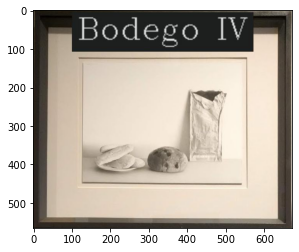

In [4]:

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'
text = pytesseract.image_to_string(qsd1_w2[0])
print(text)
plt.imshow(qsd1_w2[0])

In [5]:
BBDD_texts = data_manager.load_text(folder = "./data/BBDD/", extension = ".txt", desc = "Loading BBDD Text...")
print(BBDD_texts)

Loading BBDD Text...: 100%|████████████████████████████████████████████████████████| 287/287 [00:00<00:00, 5048.52it/s]

[('./data/BBDD/bbdd_00000.txt', "('Victor Perez-Porros', 'Des-li-zan-tes')\n"), ('./data/BBDD/bbdd_00001.txt', "('Hugo Demarco', 'Reflecting Room')\n"), ('./data/BBDD/bbdd_00002.txt', '\n'), ('./data/BBDD/bbdd_00003.txt', "('Edvard Munch', 'Youth')\n"), ('./data/BBDD/bbdd_00004.txt', "('Martin Carral', 'Ciclo espacial XXIV')\n"), ('./data/BBDD/bbdd_00005.txt', "('Mario Pasqualotto', 'Els 72 noms de Deu')\n"), ('./data/BBDD/bbdd_00006.txt', "('Gerard Sala', 'S/t')\n"), ('./data/BBDD/bbdd_00007.txt', "('Yago Hortal', 'Kl 45')\n"), ('./data/BBDD/bbdd_00008.txt', "('Josep Guinovart', 'S/t')\n"), ('./data/BBDD/bbdd_00009.txt', '\n'), ('./data/BBDD/bbdd_00010.txt', "('Agusti Puig', 'Sota la lleona')\n"), ('./data/BBDD/bbdd_00011.txt', "('Joan Hernandez Pijuan', 'Serie violetes i verds')\n"), ('./data/BBDD/bbdd_00012.txt', "('Regina Gimenez', 'Navegants')\n"), ('./data/BBDD/bbdd_00013.txt', "('Pere Santilari', 'Berenar de pastisseria')\n"), ('./data/BBDD/bbdd_00014.txt', '\n'), ('./data/BBDD/

In [6]:
BBDD_titles = data_manager.extract_title(data=BBDD_texts,index=1,desc='Extracting titles from DDBB...')
BBDD_authors = data_manager.extract_title(data=BBDD_texts,index=0,desc='Extracting authors from DDBB...')


Extracting authors from DDBB...: 100%|███████████████████████████████████████████| 287/287 [00:00<00:00, 143904.99it/s]


In [7]:
print(BBDD_authors)

['Victor Perez-Porros', 'Hugo Demarco', '', 'Edvard Munch', 'Martin Carral', 'Mario Pasqualotto', 'Gerard Sala', 'Yago Hortal', 'Josep Guinovart', '', 'Agusti Puig', 'Joan Hernandez Pijuan', 'Regina Gimenez', 'Pere Santilari', '', 'Josep Ginovart', 'Corneille', '', '', '', 'Antoni Llena', 'Josep Cisquella', 'Modest Cuixart', 'Per Krohg', 'Joan Pere Viladecans', 'Josep Guinovart', 'Victor Perez-Porro', 'Marco Palazzi', 'Robert Llimos', '', 'Francesca Llopis', 'Pablo Picasso', 'Perejaume', '', 'Jose Luis Pascual', 'Sergi Barnils', '', 'Agusti Puig', '', 'Alfred Figueras', 'Paul Klee', 'Robert Llimos', 'Enrique Barro', 'Narcis Comadira', 'Josep Segu', 'Joan Pere Viladecans', 'Lluis Lleo', 'Xavier Valls', 'Ramiro Fernandez Saus', '', 'Jordi Fulla', 'Alfred Figueras', 'Pere Santilari', 'Alfons Borrell', 'Anna-Eva Bergman', 'Alfons Borrell', '', 'Paul Klee', 'Alfred Figueras', '', 'Jens Ferdinand Willumsen', '', '', 'Edvard Munch', 'Julio Vaquero', '', '', 'Ramon Enrich', 'Jordi Isern', 'Edv

In [8]:
# Mention the installed location of Tesseract-OCR in your system
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'
#qsd2_w3_denoised = denoise_images (qsd2_w3,method='nlmeans', ksize=(3,3))
detected_titles = text_reading(data=qsd1_w2,num_images=1,desc='Reading titles from images')
detected_authors = text_reading(data=qsd1_w3,num_images=1,desc='Reading authors from images')
     

Reading authors from images: 100%|█████████████████████████████████████████████████████| 30/30 [00:31<00:00,  1.06s/it]


In [9]:
print(detected_titles)
print(detected_authors)

['sBodego IV', 'Paisatge', 'Noia al mirallj', 'Les roses', '2 segons abans del traspas', 'Lialmirall Byron', 'iSt', 'Port de mar Eivissa', ' Pintura sobre Ll ', '7 Unknown a', ' ', 'i Unknown ', 'Suite diabolica n 5 ', ' ', ' Mercat a la plaa de Manresa a', 'Rastres i transparencies ', 'Bodego  pastisseria M', ' ', '', ' Bodego ', ' ', 'The Stroll', 'Cadira florida', 'Tol al re mmoxe aimoxe Kel amt ge e', 'Te de nit', 'eLa meva mare', 's Carrer de la Plateriall', 'rie violetes i verds', 'Suite Mediterrania ', '']
['  ', ' ', ' ', 'Pere Santilari', ' Unknown Yo', 'sAgusti Puig en', ' ', 'lJose M Codina li', ' ', 's Alfred Figueras', ' Francesc Artigau ', 'Gerard Sala ', ' Antoni Llena', '   MPere Santilari i', ' Joan Ponce aoS ao', ' Josep Guinovart', 'ma jJoan Poncp', ' ', '', ' Joan Pere Viladecans- Bf a OU ae a  ind', '   Leticia Feduchi ', 'F  Sergi Barnils b', 'Xevi Vilaro', 'PYago Hor     ', ' ', 'BERN Pere Viladecans fy', '  ', 'Francesc Artigau 3', 'Modest Cuixart', '    Perejau

In [10]:
sim = Similarity()

qsd1_w2_similarities = sim.compute_string_similarities(detected_titles,BBDD_titles,desc='Computing string similarity', similarity='jaccard')
qsd1_w3_similarities = sim.compute_string_similarities(detected_authors,BBDD_authors,desc='Computing string similarity', similarity='jaccard')

Computing string similarity: 100%|█████████████████████████████████████████████████████| 30/30 [00:00<00:00, 79.37it/s]


In [11]:

top_k_qsd1_w2 = sim.get_top_k(qsd1_w2_similarities, db_files, 10, desc='Extracting top 10')
top_k_qsd1_w3 = sim.get_top_k(qsd1_w3_similarities, db_files, 10, desc='Extracting top 10')

Extracting top 10: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 15035.14it/s]


In [15]:
SAVE_RESULTS =False
K=10
predicted_results_qsd1_w2 = data_manager.save_results_1(results = top_k_qsd1_w2, path = "./week3/QSD1W2/method1", save = SAVE_RESULTS) # FOR QS WITH 1 PAINTING
expected_results_qsd1_w2 = pickle.load(file = open('./data/qsd1_w2/gt_corresps.pkl', "rb"))
predicted_results_qsd1_w3 = data_manager.save_results_1(results = top_k_qsd1_w3, path = "./week3/QSD1W3/method1", save = SAVE_RESULTS) # FOR QS WITH 1 PAINTING
expected_results_qsd1_w3 = pickle.load(file = open('./data/qsd1_w3/gt_corresps.pkl', "rb"))

metric = metrics.mapk(actual = expected_results_qsd1_w2, predicted = predicted_results_qsd1_w2, k=K)
print("MAP@{} Score: {:.4f}% ({}/{})".format(K, metric*100,int(len(predicted_results_qsd1_w2)*metric),len(predicted_results_qsd1_w2)))
metric = metrics.mapk(actual = expected_results_qsd1_w3, predicted = predicted_results_qsd1_w3, k=K)
print("MAP@{} Score: {:.4f}% ({}/{})".format(K, metric*100,int(len(predicted_results_qsd1_w3)*metric),len(predicted_results_qsd1_w3)))

MAP@10 Score: 69.4444% (20/30)
MAP@10 Score: 37.0370% (11/30)


In [13]:
K=5
predicted_results_qsd1_w2 = data_manager.save_results_1(results = top_k_qsd1_w2, path = "./week3/QSD1W2/method1", save = SAVE_RESULTS) # FOR QS WITH 1 PAINTING
expected_results_qsd1_w2 = pickle.load(file = open('./data/qsd1_w2/gt_corresps.pkl', "rb"))
predicted_results_qsd1_w3 = data_manager.save_results_1(results = top_k_qsd1_w3, path = "./week3/QSD1W3/method1", save = SAVE_RESULTS) # FOR QS WITH 1 PAINTING
expected_results_qsd1_w3 = pickle.load(file = open('./data/qsd1_w3/gt_corresps.pkl', "rb"))

metric = metrics.mapk(actual = expected_results_qsd1_w2, predicted = predicted_results_qsd1_w2, k=K)
print("MAP@{} Score: {:.4f}% ({}/{})".format(K, metric*100,int(len(predicted_results_qsd1_w2)*metric),len(predicted_results_qsd1_w2)))
metric = metrics.mapk(actual = expected_results_qsd1_w3, predicted = predicted_results_qsd1_w3, k=K)
print("MAP@{} Score: {:.4f}% ({}/{})".format(K, metric*100,int(len(predicted_results_qsd1_w3)*metric),len(predicted_results_qsd1_w3)))

MAP@5 Score: 69.4444% (20/30)
MAP@5 Score: 36.1111% (10/30)


In [14]:
K=1
predicted_results_qsd1_w2 = data_manager.save_results_1(results = top_k_qsd1_w2, path = "./week3/QSD1W2/method1", save = SAVE_RESULTS) # FOR QS WITH 1 PAINTING
expected_results_qsd1_w2 = pickle.load(file = open('./data/qsd1_w2/gt_corresps.pkl', "rb"))
predicted_results_qsd1_w3 = data_manager.save_results_1(results = top_k_qsd1_w3, path = "./week3/QSD1W3/method1", save = SAVE_RESULTS) # FOR QS WITH 1 PAINTING
expected_results_qsd1_w3 = pickle.load(file = open('./data/qsd1_w3/gt_corresps.pkl', "rb"))

metric = metrics.mapk(actual = expected_results_qsd1_w2, predicted = predicted_results_qsd1_w2, k=K)
print("MAP@{} Score: {:.4f}% ({}/{})".format(K, metric*100,int(len(predicted_results_qsd1_w2)*metric),len(predicted_results_qsd1_w2)))
metric = metrics.mapk(actual = expected_results_qsd1_w3, predicted = predicted_results_qsd1_w3, k=K)
print("MAP@{} Score: {:.4f}% ({}/{})".format(K, metric*100,int(len(predicted_results_qsd1_w3)*metric),len(predicted_results_qsd1_w3)))

MAP@1 Score: 66.6667% (20/30)
MAP@1 Score: 20.0000% (6/30)
